<a href="https://colab.research.google.com/github/ShuGe-MIT/Diffusion-KDE/blob/main/diffusion_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import torch
from scipy.special import erf
from math import*
from scipy.integrate import quad as itg
from torch.utils.data import DataLoader, Dataset

# import argparse
# parser=argparse.ArgumentParser(description="Job launcher")

# parser.add_argument("-n",type=int)
# parser.add_argument("-m",type=float)  #norm of mu. Set to 1. in the whole manuscipt.
# parser.add_argument("-s",type=float)  #sigma

# args=parser.parse_args()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# nrm=args.m
# sigma=args.s
nrm = 8
sigma = 1.5

n_list=[2,4,6,8,16,32,64,128,256,512,1024]
# ntot=n_list[args.n]   #number of samples
ntot = n_list[3]

# d=50000  #dimension of the data
d = 5000



gen0 = torch.Generator().manual_seed(42)
gen1 = torch.Generator().manual_seed(67)
gen3 = torch.Generator().manual_seed(4122)



xi=torch.randn(ntot,d,generator=gen0)  #x_0^\mu. We fixed the random seed for reproducibility
eta=torch.randn(ntot,d,generator=gen1) #z^\mu. We fixed the random seed for reproducibility

s=torch.sign(torch.randn(ntot,generator=gen3)[:ntot])   #s^\mu

xi_tot=torch.sum(xi.T*s,1).flatten()/ntot  #xi vector
eta_tot=torch.sum(eta.T*s,1).flatten()/ntot #eta vector
xi_tot=xi_tot.numpy()
eta_tot=eta_tot.numpy()

μ=torch.ones(d)
mu=μ.numpy()

summary={"Mag":[],    "Mag_std":[],"t":[],"MagXi":[],"MagEta":[], "Cosine":[],"Norm":[]}



Nsteps=100   #number of discretization steps for the ODE
dt=1/Nsteps  #time step


#Schedule functions
def alpha(t):
  return t
def beta(t):
  return 1-t

#
def get_x(n,μ,σ,test=False):
    x=s.reshape(n,1)@μ.reshape(1,d)
    x+=eta*σ
    return x


def get_y(n,μ,σ,t,test=False):
    x=get_x(n,μ,σ,test=test)
    y=x*alpha(t)+xi*beta(t)
    return x.to(device),y.to(device)

class generate_data(Dataset):   #data loader object
  def __init__(self,n,μ,sigma=.5,t=.5, test=False):
    self.X,self.Y=get_y(n,μ,sigma,t,test)
    self.μ=μ
    self.sigma=sigma
    self.t=t
    self.samples=n

  def __getitem__(self,idx):
    return self.X[idx].to(device),self.Y[idx].to(device)

  def __len__(self):
    return self.samples


class AE_tied(torch.nn.Module): #DAE
    def __init__(self, d):
        super(AE_tied, self).__init__()

        self.b=torch.nn.Parameter(torch.Tensor([1]))   #skip connection
        self.w=torch.nn.Parameter(torch.randn(d))      #network weight

    def forward(self, x):
        identity=x
        h=torch.sign(x@self.w/np.sqrt(d))
        yhat = h.reshape(x.shape[0],1)@self.w.reshape(1,d)
        yhat+=self.b*identity
        return yhat

def quadloss(ypred, y):      #Loss function. The regularization enters at the level of the optimizer as the weight decay
    return torch.sum((ypred-y)**2)/2

def train(train_loader, t):
    global X
    ae=AE_tied(d).to(device)

    optimizer = torch.optim.Adam([{'params': [ae.w],"weight_decay":1e-1},{'params': [ae.b],"weight_decay":0.}],lr=.04)
    ######## Training the DAE
    # for tt in range(6000):
    for tt in range(2000):
        for x,y in train_loader:   #Optimization steps

          y_pred = ae(y)
          loss = quadloss(y_pred,x)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        # if tt%100==0:
        #   print(tt,loss.item())
    ###### Computing the corresponding velocity
    β=beta(t)
    α=alpha(t)

    w_=ae.w.cpu().detach().numpy()
    c=float(ae.b)

    bhat=(np.sign(X@w_).reshape(-1,1))@w_.reshape(1,-1)/β

    lin=(1+α/β)*(X*c)-X/β
    if β==0:
        lin=c*X
    v=(α+β)*bhat+lin
    ####### ODE step
    X+=v*dt

    Mt=((X.T*np.sign(X@mu)).T)@mu/d
    MXi=((X.T*np.sign(X@mu)).T)@xi_tot/d
    MEta=((X.T*np.sign(X@mu)).T)@eta_tot/d/sigma

    X_=(X.T*np.sign(X@mu)).T
    Simi=X_@mu/np.sqrt(d)/np.sqrt(np.sum(X_**2, 1))
    summary["Mag"].append(Mt.mean()); summary["Mag_std"].append(Mt.std()); summary["t"].append(t+dt); summary["MagXi"].append(MXi.mean())
    summary["MagEta"].append(MEta.mean()); summary["Cosine"].append(Simi.mean()); summary["Norm"].append(np.sum(X_**2)/X_.shape[0]/d)

In [3]:
N=1000
X=np.random.randn(N,d)   #N samples which will be transported by the flow. At time 0, X~\rho_0
                         #At time t=1, X~\hat{\rho}_1

Mt=((X.T*np.sign(X@mu)).T)@mu/d
MXi=((X.T*np.sign(X@mu)).T)@xi_tot/d
MEta=((X.T*np.sign(X@mu)).T)@eta_tot/d

X_=(X.T*np.sign(X@mu)).T
Simi=X_@mu/np.sqrt(d)/np.sqrt(np.sum(X_**2, 1))
summary["Mag"].append(Mt.mean()); summary["Mag_std"].append(Mt.std()); summary["t"].append(0); summary["MagXi"].append(MXi.mean())
summary["MagEta"].append(MEta.mean()); summary["Cosine"].append(Simi.mean()); summary["Norm"].append(np.sum(X_**2)/X_.shape[0]/d)

In [4]:
ts=np.linspace(0.,1,Nsteps)[:-1]
res = []
for t in ts:
  X_train=generate_data(ntot,μ,sigma=sigma,t=t)
  train_loader=DataLoader(X_train,batch_size=int(ntot))

  train(train_loader,t)
  res.append((t, ((X.T*np.sign(X@mu)).T)))

# for t, mu in res:
#   print(t, ((X.T*np.sign(X@mu)).T))

mu_simu=((X.T*np.sign(X@mu)).T).mean(axis=0)   #computing \hat{\mu}, the cluster mean of the estimated density

In [5]:
len(res)

99

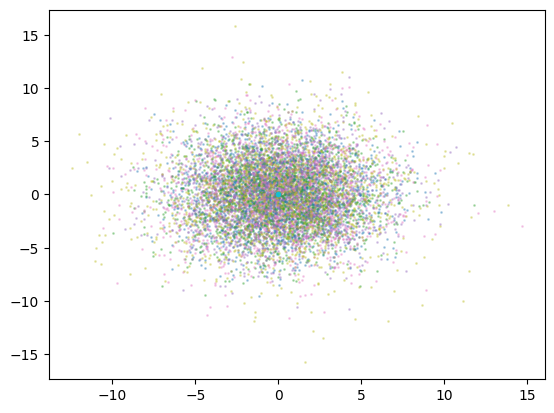

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.figure()
for t, mu in res[::10]:
  # pca transformation of mu
  pca = PCA(n_components=2)
  pca.fit(mu)
  mu_pca = pca.transform(mu)
  plt.scatter(mu_pca[:,0],mu_pca[:,1],label=t, s=1, alpha = 0.3)
  plt.scatter(mu_pca[:,0].mean(),mu_pca[:,1].mean(),label=t, s=10)
plt.show()

In [ ]:
np.save("data/mu_n{}_norm{}_sig{}.npy".format(ntot,nrm,sigma),mu_simu)

In [ ]:
mu_simu

array([1.01421605, 0.23957835, 0.88485557, 1.05986413, 0.73747364,
       1.09056495, 1.19103789, 1.38707937, 1.16011364, 0.6543879 ,
       1.17164645, 1.42744426, 1.13333396, 0.80110275, 1.10920033,
       0.87582977, 0.23955916, 1.60767438, 1.57152204, 0.25509226,
       0.94966165, 0.92913467, 0.67707716, 1.28563834, 0.62920803,
       0.64621888, 0.83533815, 0.74871132, 0.41834328, 0.78673318,
       0.76574742, 0.841491  , 1.12548439, 0.99485158, 0.70445978,
       0.43722085, 1.13719182, 1.31476939, 1.12525   , 0.65686074,
       0.82776598, 0.8804846 , 0.72663514, 1.4645121 , 1.02108998,
       0.44902449, 0.5216775 , 0.91204593, 1.29709438, 0.6123553 ,
       1.20869505, 0.64848314, 1.62212276, 0.1895115 , 0.5476409 ,
       1.1445532 , 1.19763379, 0.29152543, 0.82658356, 1.19009528,
       1.01071844, 1.05142533, 0.12783943, 1.03983585, 0.89251163,
       1.04429609, 0.95835337, 1.59364778, 0.99008454, 1.12149339,
       1.0691964 , 0.76852328, 0.90181895, 0.36823175, 0.46049